In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy import units as u
from itertools import product
import yssbtmpy as tm

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Circle, FancyArrowPatch, Arc

from multiprocessing import Pool


from accutil import (set_perpmodel, set_phaethon, set_model_aspect,
                     set_particle, linticker, 
                     logxticker, logyticker, calc_traj, CHEMDICT,
                    QprbarSpline, QprbarSunSpline, QPRDIR)

FIGDIR = Path("./figs")
TH_0_CALC = np.array([90])
PH_0_CALC = np.arange(0, 360, 10)
DIAM_CALC = np.array([0.5, 1, 5, 10]) * u.km
HEIGHT_CALC_ACC = [0.1, 5, 100] *u.m
MAX_H_STEP = 300*u.m

chemkeys = list(CHEMDICT.keys())
n_chem = len(chemkeys)

Escape speed on equator = 1.232 m / s
075: 
1.0 µm (   escape    ): 13.77 min, 04.98 m/s, 340.0 m
2.0 µm (   escape    ): 18.54 min, 03.63 m/s, 620.0 m
080: 
1.0 µm ( min_height  ): 06.77 min, 01.10 m/s, 000.0 m
2.0 µm (  max_time   ): 30.08 min, 01.82 m/s, 620.0 m
085: 
1.0 µm ( min_height  ): 01.62 min, 01.23 m/s, 000.0 m
2.0 µm ( min_height  ): 03.73 min, 00.38 m/s, 000.0 m
090: 
1.0 µm ( min_height  ): 00.15 min, 00.76 m/s, 000.0 m
2.0 µm ( min_height  ): 00.22 min, 00.97 m/s, 000.0 m
095: 
1.0 µm ( min_height  ): 00.04 min, 01.12 m/s, 000.0 m
2.0 µm ( min_height  ): 00.07 min, 01.16 m/s, 000.0 m
100: 
1.0 µm ( min_height  ): 00.03 min, 01.15 m/s, 000.0 m
2.0 µm ( min_height  ): 00.06 min, 01.17 m/s, 000.0 m
105: 
1.0 µm ( min_height  ): 00.02 min, 01.16 m/s, 000.0 m
2.0 µm ( min_height  ): 00.06 min, 01.16 m/s, 000.0 m
255: 
1.0 µm ( min_height  ): 00.04 min, 01.34 m/s, 000.0 m
2.0 µm (   escape    ): 05.55 min, 07.88 m/s, 320.1 m
260: 
1.0 µm ( min_height  ): 00.05 min, 01.38 m/s

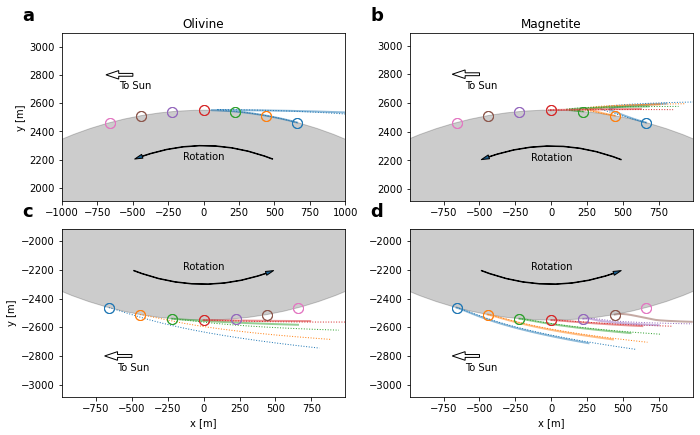

In [13]:
phaemodel = set_phaethon(true_anom=0, ti_rh_correct=False)
phaemodel.calc_temp(full=False)

dt = 0.025
# tmax = np.inf  # sec
tmax = 30*60  # sec
traj_kw = dict(init_height=1*u.cm, r0_radius=0.01, dt=dt,
               init_th=90, max_h_step=5*u.m, 
               nstep=tmax//dt, return_halt_code=True) 
circ_kw = dict(xy=(0, 0), radius=phaemodel.diam_eff.to_value(u.m)/2,
               color='k', alpha=0.2, fill=True)
v_esc_eq = np.sqrt(2*tm.GG_Q*phaemodel.mass/phaemodel.diam_eff/2).to(u.m/u.s)
print(f"Escape speed on equator = {v_esc_eq:.3f}")
ph_m = np.arange(75, 106, 5)  # Morning
ph_e = np.arange(255, 286, 5)  # Evening

rads = dict(mag=[1, 2], oliv=[1, 2])
lss = ['-', ':']
lws = [2, 1]
alphas = [0.5, 1]

info_str = "{:.1f} µm ({:^13s}): {:05.2f} min, {:05.2f} m/s, {:05.1f} m"

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i, chem in enumerate(chemkeys):
    ax_m = axs[0, i]  # Morning
    ax_e = axs[1, i]  # Evening
    c_m = Circle(**circ_kw)
    c_e = Circle(**circ_kw)

    for ax, phs in zip([ax_m, ax_e], [ph_m, ph_e]):
        for i_ph, init_ph in enumerate(phs):
            print(f"{init_ph:03.0f}: ")
            color = plt.cm.tab10(i_ph%10)
            for j, r in enumerate(rads[chem]):
                p, code = calc_traj(radius=r, sb=phaemodel, chem=chem, 
                                    init_ph=init_ph, **traj_kw)
                print(info_str.format(r, 
                                      code,
                                      p.trace_time[-1]/60, 
                                      np.linalg.norm(p.trace_vel_xyz[-1]), 
                                      p.trace_height[-1]))
                x = p.trace_pos_xyz[::50, 0]
                y = p.trace_pos_xyz[::50, 1]
                ax.plot(x[0], y[0], 'o', ms=10, mfc='none', mec=color)
                if code != 'escape':
                    continue
                ax.plot(x, y, ls=lss[j], lw=lws[j], alpha=alphas[j], color=color)

    ax_m.add_artist(c_m)
    ax_e.add_artist(c_e)

for ax in axs.flatten():
    ax.axis('equal')

xlim = (-1000, 1000)
ylim = np.array([2000, 3000])
axs[0, 0].set(xlim=xlim, ylim=ylim,
              title="Olivine",
              ylabel="y [m]")
axs[0, 1].set(xlim=xlim, ylim=ylim,
              title="Magnetite")
axs[1, 0].set(xlim=xlim, ylim=-1*ylim[::-1],
              ylabel="y [m]", xlabel="x [m]")
axs[1, 1].set(xlim=xlim, ylim=-1*ylim[::-1],
              xlabel="x [m]")
plt.tight_layout()

for ax in axs.flatten():
    ysign = np.sign(ax.get_ylim()[0])
    xpos_sun = xlim[0] + 500
    ypos_sun = ysign * (ylim.max() - 200)
    xpos_rot = [xlim[1] - 500, xlim[0] + 500]
    ypos_rot = ysign * (ylim.min() + 200)    
    rotrad = 0.2
    
    ax.arrow(xpos_sun, ypos_sun, -100, 0, width=20, fill=False)
    ax.text(xpos_sun - 100, ypos_sun - 100, 'To Sun')
    rotarrow = FancyArrowPatch((xpos_rot[::int(ysign)][0], ypos_rot), 
                               (xpos_rot[::int(ysign)][1], ypos_rot),
                               connectionstyle=f"arc3,rad={rotrad}",
                               arrowstyle="Simple,tail_width=0.5,head_width=4,head_length=8")
    ax.add_patch(rotarrow)
    ax.text(np.mean(xpos_rot), ypos_rot, "Rotation", horizontalalignment='center')


for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.14, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

plt.savefig(FIGDIR / f"phae_acc_trajectory.png", dpi=300)
plt.savefig(FIGDIR / f"phae_acc_trajectory.pdf")

Escape speed on equator = 1.232 m / s
075: 
1.0 µm (   escape    ): 06.37 min, 07.48 m/s, 210.0 m
2.0 µm (   escape    ): 09.37 min, 05.85 m/s, 360.0 m
080: 
1.0 µm (   escape    ): 05.26 min, 08.03 m/s, 185.0 m
2.0 µm (   escape    ): 08.32 min, 06.10 m/s, 320.1 m
085: 
1.0 µm (   escape    ): 04.24 min, 08.58 m/s, 155.0 m
2.0 µm (   escape    ): 07.36 min, 06.37 m/s, 275.0 m
090: 
1.0 µm (   escape    ): 03.21 min, 09.08 m/s, 120.0 m
2.0 µm (   escape    ): 06.41 min, 06.65 m/s, 235.0 m
095: 
1.0 µm ( min_height  ): 00.04 min, 01.10 m/s, 000.0 m
2.0 µm ( min_height  ): 00.22 min, 00.98 m/s, 000.0 m
100: 
1.0 µm ( min_height  ): 00.03 min, 01.15 m/s, 000.0 m
2.0 µm ( min_height  ): 00.07 min, 01.15 m/s, 000.0 m
105: 
1.0 µm ( min_height  ): 00.02 min, 01.17 m/s, 000.0 m
2.0 µm ( min_height  ): 00.05 min, 01.17 m/s, 000.0 m
255: 
1.0 µm ( min_height  ): 00.06 min, 01.41 m/s, 000.0 m
2.0 µm (   escape    ): 05.55 min, 07.87 m/s, 355.0 m
260: 
1.0 µm (   escape    ): 02.97 min, 10.66 m/s

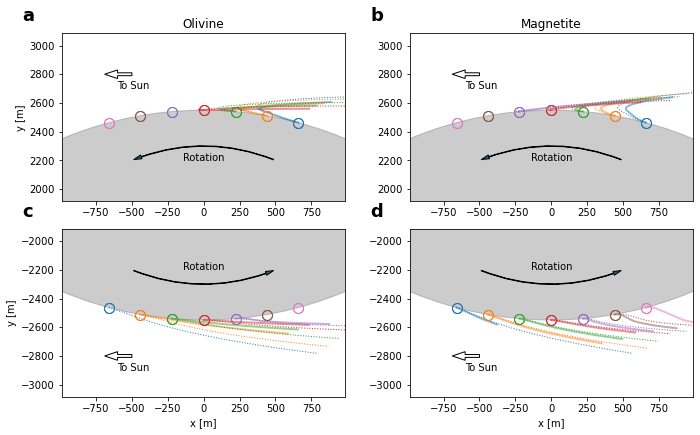

In [8]:
phaemodel = set_phaethon(true_anom=0, ti_rh_correct=True)
phaemodel.calc_temp(full=False)

dt = 0.025
# tmax = np.inf  # sec
tmax = 30*60  # sec
traj_kw = dict(init_height=1*u.cm, r0_radius=0.01, dt=dt,
               init_th=90, max_h_step=5*u.m, 
               nstep=tmax//dt, return_halt_code=True) 
circ_kw = dict(xy=(0, 0), radius=phaemodel.diam_eff.to_value(u.m)/2,
               color='k', alpha=0.2, fill=True)
v_esc_eq = np.sqrt(2*tm.GG_Q*phaemodel.mass/phaemodel.diam_eff/2).to(u.m/u.s)
print(f"Escape speed on equator = {v_esc_eq:.3f}")
ph_m = np.arange(75, 106, 5)  # Morning
ph_e = np.arange(255, 286, 5)  # Evening

rads = dict(mag=[1, 2], oliv=[1, 2])
lss = ['-', ':']
lws = [2, 1]
alphas = [0.5, 1]

info_str = "{:.1f} µm ({:^13s}): {:05.2f} min, {:05.2f} m/s, {:05.1f} m"

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i, chem in enumerate(chemkeys):
    ax_m = axs[0, i]  # Morning
    ax_e = axs[1, i]  # Evening
    c_m = Circle(**circ_kw)
    c_e = Circle(**circ_kw)

    for ax, phs in zip([ax_m, ax_e], [ph_m, ph_e]):
        for i_ph, init_ph in enumerate(phs):
            print(f"{init_ph:03.0f}: ")
            color = plt.cm.tab10(i_ph%10)
            for j, r in enumerate(rads[chem]):
                p, code = calc_traj(radius=r, sb=phaemodel, chem=chem, 
                                    init_ph=init_ph, **traj_kw)
                print(info_str.format(r, 
                                      code,
                                      p.trace_time[-1]/60, 
                                      np.linalg.norm(p.trace_vel_xyz[-1]), 
                                      p.trace_height[-1]))
                x = p.trace_pos_xyz[::50, 0]
                y = p.trace_pos_xyz[::50, 1]
                ax.plot(x[0], y[0], 'o', ms=10, mfc='none', mec=color)
                if code != 'escape':
                    continue
                ax.plot(x, y, ls=lss[j], lw=lws[j], alpha=alphas[j], color=color)

    ax_m.add_artist(c_m)
    ax_e.add_artist(c_e)

for ax in axs.flatten():
    ax.axis('equal')

xlim = (-1000, 1000)
ylim = np.array([2000, 3000])
axs[0, 0].set(xlim=xlim, ylim=ylim,
              title="Olivine",
              ylabel="y [m]")
axs[0, 1].set(xlim=xlim, ylim=ylim,
              title="Magnetite")
axs[1, 0].set(xlim=xlim, ylim=-1*ylim[::-1],
              ylabel="y [m]", xlabel="x [m]")
axs[1, 1].set(xlim=xlim, ylim=-1*ylim[::-1],
              xlabel="x [m]")
plt.tight_layout()

for ax in axs.flatten():
    ysign = np.sign(ax.get_ylim()[0])
    xpos_sun = xlim[0] + 500
    ypos_sun = ysign * (ylim.max() - 200)
    xpos_rot = [xlim[1] - 500, xlim[0] + 500]
    ypos_rot = ysign * (ylim.min() + 200)    
    rotrad = 0.2
    
    ax.arrow(xpos_sun, ypos_sun, -100, 0, width=20, fill=False)
    ax.text(xpos_sun - 100, ypos_sun - 100, 'To Sun')
    rotarrow = FancyArrowPatch((xpos_rot[::int(ysign)][0], ypos_rot), 
                               (xpos_rot[::int(ysign)][1], ypos_rot),
                               connectionstyle=f"arc3,rad={rotrad}",
                               arrowstyle="Simple,tail_width=0.5,head_width=4,head_length=8")
    ax.add_patch(rotarrow)
    ax.text(np.mean(xpos_rot), ypos_rot, "Rotation", horizontalalignment='center')


for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.14, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

plt.savefig(FIGDIR / f"phae_acc_trajectory_ti_rh_corrected.png", dpi=300)
plt.savefig(FIGDIR / f"phae_acc_trajectory_ti_rh_corrected.pdf")